In [ ]:
# @title 1. System Setup & Dependencies
# Installing SHAP for explainability and Joblib for saving models
!pip install opencv-python-headless scikit-learn scikit-image matplotlib seaborn xgboost shap joblib --quiet

import os
import cv2
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from skimage.feature import local_binary_pattern

# Setup directories for persistence
!mkdir -p saved_models
!mkdir -p dataset/real
!mkdir -p dataset/ai

print("✅ System Ready: Persistence & Explainability engines loaded.")

✅ System Ready: Persistence & Explainability engines loaded.


In [ ]:
# @title 2. Feature Extraction Engine (The "Eyes")
# Same robust logic as before, but wrapped for efficiency.

class FeatureExtractor:
    def __init__(self, img_size=(256, 256)):
        self.img_size = img_size

    def preprocess(self, img_path):
        try:
            img = cv2.imread(img_path)
            if img is None: return None
            return cv2.resize(img, self.img_size)
        except: return None

    def get_fft_features(self, img):
        """Detects upsampling artifacts (checkerboard patterns)."""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-9)
        h, w = magnitude_spectrum.shape
        center = (w // 2, h // 2)
        y, x = np.indices((h, w))
        r = np.sqrt((x - center[0])**2 + (y - center[1])**2).astype(int)
        tbin = np.bincount(r.ravel(), magnitude_spectrum.ravel())
        nr = np.bincount(r.ravel())
        radial_profile = tbin / (nr + 1e-9)
        #
        return radial_profile[:60]

    def get_ela_features(self, img, quality=90):
        """Detects compression anomalies."""
        _, encoded_img = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
        decoded_img = cv2.imdecode(encoded_img, 1)
        ela_img = np.abs(img.astype("float32") - decoded_img.astype("float32"))
        stats = []
        for channel in cv2.split(ela_img):
            stats.extend([np.mean(channel), np.std(channel), np.max(channel)])
        return np.array(stats)

    def get_lbp_features(self, img, P=8, R=1):
        """Detects unnatural texture smoothness."""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P, R, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        #
        return hist

    def extract_all(self, img_path):
        img = self.preprocess(img_path)
        if img is None: return None
        return np.concatenate([
            self.get_fft_features(img),
            self.get_ela_features(img),
            self.get_lbp_features(img)
        ])

print("✅ Feature Engine Ready.")

✅ Feature Engine Ready.


In [ ]:
# @title 3. The Model Manager (With Deduplication & Balancing)
# Upgraded to handle Class Imbalance and Duplicate Images automatically.

import hashlib
import pandas as pd
import joblib
from collections import Counter

class AIModelManager:
    def __init__(self, model_dir='saved_models'):
        self.model_path = os.path.join(model_dir, 'voting_ensemble.pkl')
        self.data_path = os.path.join(model_dir, 'training_data.joblib')
        self.registry_path = os.path.join(model_dir, 'image_registry.pkl') # Stores hashes
        self.extractor = FeatureExtractor()

        # Initialize or Load Registry (Set of image hashes)
        if os.path.exists(self.registry_path):
            self.registry = joblib.load(self.registry_path)
        else:
            self.registry = set() # Empty set to store unique hashes

    def get_image_hash(self, img):
        """Creates a unique fingerprint for the image pixel data."""
        return hashlib.md5(img.tobytes()).hexdigest()

    def load_model(self):
        if os.path.exists(self.model_path):
            return joblib.load(self.model_path)
        return None

    def save_system(self, model, X, y):
        print(f"💾 Saving system state...")
        joblib.dump(model, self.model_path)
        joblib.dump((X, y), self.data_path)
        joblib.dump(self.registry, self.registry_path) # Save the registry of seen images
        print("✅ Model, Data, and Registry saved.")

    def train_or_update(self, real_dir, ai_dir, force_retrain=False):
        # 1. Load Existing Data
        X_old, y_old = np.empty((0, 0)), np.empty(0)
        if os.path.exists(self.data_path) and not force_retrain:
            X_old, y_old = joblib.load(self.data_path)
            print(f"📂 Loaded {len(X_old)} existing records.")

        # 2. Extract features ONLY from NEW unique images
        print("🔍 Scanning folders for new data...")
        new_feats, new_labels = [], []
        skipped_count = 0

        def process_folder(path, label):
            count = 0
            skipped = 0
            if not os.path.exists(path): return 0, 0

            for f in os.listdir(path):
                img_path = os.path.join(path, f)
                # Pre-check: Read image to get hash
                img = self.extractor.preprocess(img_path)
                if img is None: continue

                # HASH CHECK: Have we seen this exact image before?
                img_hash = self.get_image_hash(img)
                if img_hash in self.registry:
                    skipped += 1
                    continue # Skip this loop iteration

                # If new, extract features and add to registry
                feat = self.extractor.extract_all(img_path) # extracting again to be safe with path logic
                if feat is not None:
                    new_feats.append(feat)
                    new_labels.append(label)
                    self.registry.add(img_hash) # Mark as seen
                    count += 1
            return count, skipped

        c_real, s_real = process_folder(real_dir, 0)
        c_ai, s_ai = process_folder(ai_dir, 1)

        print(f"⚡ Added {c_real} Real, {c_ai} AI images.")
        print(f"🛡️ Skipped {s_real + s_ai} duplicates (already trained).")

        # 3. Combine Data
        if len(new_feats) > 0:
            X_new = np.array(new_feats)
            y_new = np.array(new_labels)

            if X_old.shape[0] > 0:
                X_final = np.vstack((X_old, X_new))
                y_final = np.concatenate((y_old, y_new))
            else:
                X_final, y_final = X_new, y_new
        else:
            print("⚠️ No new unique images found. Retraining on existing data.")
            X_final, y_final = X_old, y_old

        if len(X_final) == 0:
            print("❌ No data available to train.")
            return None, None, None

        # 4. Handle Imbalance & Train
        # Check counts
        counter = Counter(y_final)
        print(f"📊 Class Distribution: Real={counter[0]}, AI={counter[1]}")

        print(f"🧠 Training Ensemble (Balanced Mode)...")

        # KEY CHANGE: class_weight='balanced'
        # This tells the model to penalize mistakes on the minority class more heavily
        svm = SVC(kernel='rbf', probability=True, class_weight='balanced')
        rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

        # XGBoost/GradientBoosting handles weights differently, but relies on the others
        # in the voting ensemble to offset imbalance.
        xgb = GradientBoostingClassifier(n_estimators=100)

        ensemble = VotingClassifier(
            estimators=[('svm', svm), ('rf', rf), ('xgb', xgb)],
            voting='soft'
        )

        ensemble.fit(X_final, y_final)

        # 5. Save everything
        self.save_system(ensemble, X_final, y_final)

        return ensemble, X_final, y_final

# Initialize Manager
manager = AIModelManager()
print("✅ Deduplication & Balancing Manager Ready.")

✅ Deduplication & Balancing Manager Ready.


📂 Loaded 224 existing records.
🔍 Scanning folders for new data...
⚡ Added 0 Real, 0 AI images.
🛡️ Skipped 74 duplicates (already trained).
⚠️ No new unique images found. Retraining on existing data.
📊 Class Distribution: Real=136, AI=88
🧠 Training Ensemble (Balanced Mode)...
💾 Saving system state...
✅ Model, Data, and Registry saved.

🏆 Model Accuracy: 100.00%

🧐 Generating Explanations (SHAP)...


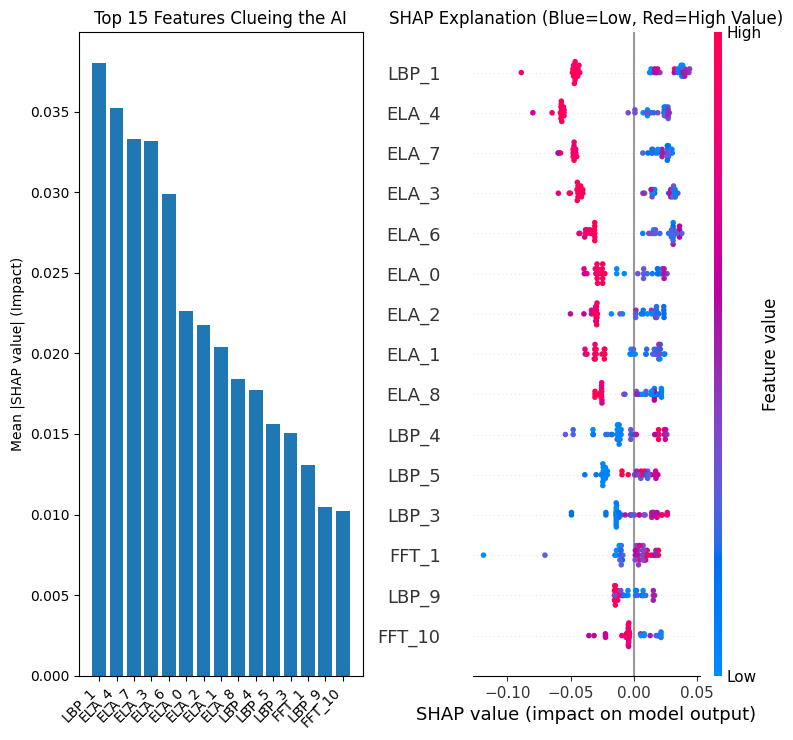

In [ ]:
# @title 4. Execution: Train/Update & Explain (FIXED)
# Run this cell whenever you add images to the folders.

import numpy as np
import shap
import matplotlib.pyplot as plt

# 1. Run the Training Cycle
model, X, y = manager.train_or_update('dataset/real', 'dataset/ai')

if model is not None and len(X) > 10:
    # Split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # 2. Basic Evaluation
    preds = model.predict(X_test)
    print(f"\n🏆 Model Accuracy: {accuracy_score(y_test, preds)*100:.2f}%")

    # 3. EXPLAINABILITY (The "Why")
    print("\n🧐 Generating Explanations (SHAP)...")

    # We explain the Random Forest part of the ensemble
    rf_model = model.named_estimators_['rf']
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test)

    # --- BUG FIX: HANDLE SHAP OUTPUT SHAPES DYNAMICALLY ---
    # Case A: shap_values is a list (e.g., [Class0_Matrix, Class1_Matrix])
    if isinstance(shap_values, list):
        shap_vals_target = shap_values[1] # Class 1 (AI)
    # Case B: shap_values is a single array (newer SHAP versions for binary)
    else:
        # If shape is (Samples, Features, 2), take the second slice
        if len(shap_values.shape) == 3:
            shap_vals_target = shap_values[:, :, 1]
        # If shape is (Samples, Features), use it directly
        else:
            shap_vals_target = shap_values

    # --- BUG FIX: DYNAMIC FEATURE NAMES ---
    # We generate names based on the ACTUAL feature count in X_test
    # instead of hardcoding ranges that might mismatch.
    n_features = X_test.shape[1]

    # Expected counts
    n_fft = 60
    n_ela = 9
    n_lbp = 10

    # If counts match our logic, use specific names
    if n_features == (n_fft + n_ela + n_lbp):
        feature_names = [f"FFT_{i}" for i in range(n_fft)] + \
                        [f"ELA_{i}" for i in range(n_ela)] + \
                        [f"LBP_{i}" for i in range(n_lbp)]
    else:
        # Fallback if counts differ (prevents crashing)
        print(f"⚠️ Feature count mismatch (Expected 79, got {n_features}). Using generic names.")
        feature_names = [f"Feature_{i}" for i in range(n_features)]

    # Visualization
    plt.figure(figsize=(20, 10))

    # Plot 1: Feature Importance Bar Chart
    plt.subplot(1, 2, 1)

    # Calculate mean absolute SHAP value for importance
    importances = np.abs(shap_vals_target).mean(axis=0)
    indices = np.argsort(importances)[::-1][:15] # Top 15

    plt.title("Top 15 Features Clueing the AI")
    plt.bar(range(15), importances[indices], align="center")
    plt.xticks(range(15), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.ylabel("Mean |SHAP value| (Impact)")

    # Plot 2: SHAP Summary (Beeswarm)
    plt.subplot(1, 2, 2)
    plt.title("SHAP Explanation (Blue=Low, Red=High Value)")

    # Now this call uses the correctly extracted matrix and names
    shap.summary_plot(shap_vals_target, X_test, feature_names=feature_names, show=False, max_display=15)

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Add images to 'dataset/real' and 'dataset/ai' to start.")